In [1]:
import sys
sys.path.append('../../PI_GP_regressor') 

from main_class import PhysicsInformedGP_regressor
from kernels.kernel_heat_equation import gram_Matrix_jax,k_ff_jax, k_fu_jax, k_uf_jax, k_uu_jax
import numpy as np

In [2]:
# first we put the kernel parts into a list
kernel_list = [gram_Matrix_jax, k_uu_jax, k_uf_jax, k_fu_jax, k_ff_jax]
#then we define the parameters for the kernel
hyperparameters = ["l_x", "sigma_f","l_t", "alpha"]
#now we can define our model. The model needs the kernel list and the hyperparameters, aswell as the timedependence
model_heat_equation = PhysicsInformedGP_regressor(kernel_list,timedependence=True, params=hyperparameters,Dimensions=2)
model_heat_equation.set_name_kernel("Wave_equation")
#now we create the training data and a validation set
n_training_points = 20
noise = [1e-8,1e-8]
model_heat_equation.set_training_data("heat_data_paper.csv",n_training_points, noise,[5,12])

n_validation_points = 2000  #for calculating the MSE
print(model_heat_equation.D)
model_heat_equation.set_validation_data(n_validation_points)
#model_heat_equation.plot_raw_data(True,False)

2


 c:\Users\leitg\anaconda3\envs\jax_cpu\Lib\site-packages\scipy\stats\_qmc.py:804: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
 c:\Users\leitg\anaconda3\envs\jax_cpu\Lib\site-packages\scipy\stats\_qmc.py:804: UserWarning:The balance properties of Sobol' points require n to be a power of 2.


Now we can train the model. We can choose different methods for the training.   
  -CG: conjugate gradient --- fast but often not very accurate    
  -TNC: truncated Newton --- slower but more accurate     
  -L-BFGS-B: limited memory BFGS --- fast and accurate (not always for some reason)   

generally TNC is the best choice

In [22]:
#for the training we first need to define the initial parameters for the restarts
model_heat_equation.jitter = 1e-6
def get_initial_values():
    """returns the initial values for the hyperparameters
    for the length scales we initialize them randomly as log(l) ~ U(-1.3,1)
    """
    rng = np.random.default_rng()
    theta_initial = np.zeros((4))
    theta_initial[0] = np.exp(rng.uniform(-1.3, 0.3, 1))  #lx
    theta_initial[1] = rng.uniform(0, 1, 1)               #sigma_f
    theta_initial[2] = np.exp(rng.uniform(-1.3, 0.3, 1))  #lt
    theta_initial[3] = rng.uniform(0, 2, 1)               #c
    return theta_initial

n_restarts = 1000; n_threads = -1
opt_params_dict = {'theta_initial': get_initial_values,   #needed for all optimization methods
                    'bounds': ((1e-2, None), (1e-5, None), (1e-3, None),(1e-2, None)), #needed for TNC and L-BFGS-B
                    'gtol': 1e-6}

model_heat_equation.train("TNC",n_restarts, n_threads,opt_params_dict)

100%|██████████| 1000/1000 [01:28<00:00, 11.33it/s]


 message: Converged (|f_n-f_(n-1)| ~= 0)
 success: True
  status: 1
     fun: -6.121881484985352
       x: [ 3.585e-01  1.832e+00  1.192e+00  9.997e-01]
     nit: 13
     jac: [-3.500e+00 -1.469e+00 -7.344e-01 -9.375e+00]
    nfev: 90


In [23]:
model_heat_equation.get_params()

array([0.35849054, 1.83183638, 1.19238995, 0.99971619])

In [3]:
#old results
model_heat_equation.set_params([0.3540676 , 1.19323111, 1.00905818, 0.99905218]) # -4.077024459838867
model_heat_equation.set_params([0.36201261, 1.58119246, 1.08855962, 0.99929574]) # -5.320425033569336
model_heat_equation.set_params([0.32882741, 1.53232479, 1.20066665, 1.00004202]) # -4.98200798034668
model_heat_equation.set_params([0.34349067, 1.84435259, 1.33290575, 0.99966288])# -5.66191291809082
model_heat_equation.set_params([0.34374673, 1.55940157, 1.12337721, 1.00042015]) #-5.345491409301758

In [4]:
model_heat_equation.jitter = 1e-6
model_heat_equation.set_axis_labels("x","t")
n_test_points = 100
x_star, t_star = np.meshgrid(np.linspace(0, 1, n_test_points), np.linspace(0, 1, n_test_points))
X_star = np.hstack((x_star.reshape(-1, 1), t_star.reshape(-1, 1)))
model_heat_equation.predict_model(X_star)
model_heat_equation.error()
#print(model_heat_equation)
var = model_heat_equation.var_u
model_heat_equation.var_u.min()

Array(-7.1525574e-07, dtype=float32)

{'u': 0.003965262640370188, 'f': 0.008212780019398418}

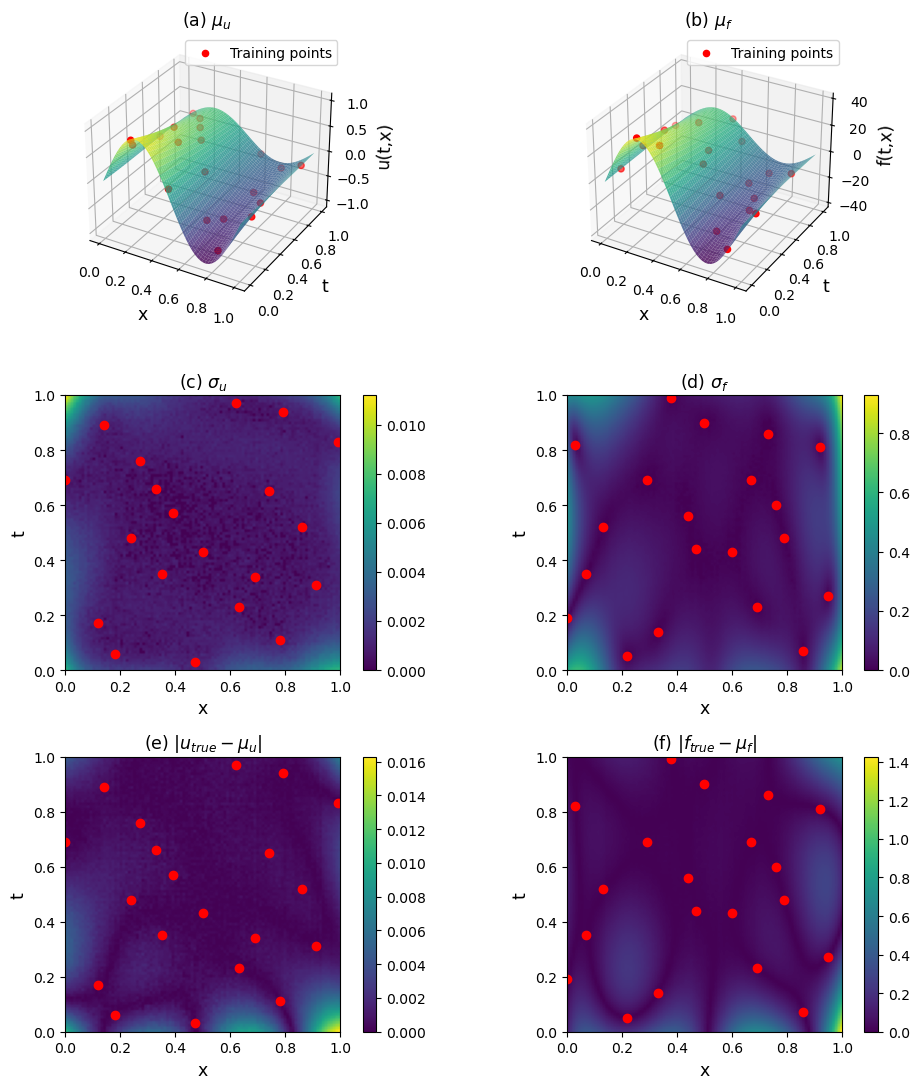

In [5]:
model_heat_equation.plot_merged_2d_plots(X_star,"merged_plots.png",figsize=(10,11))
model_heat_equation.rel_l2_error

We can now do the same with the GPy library with a non modified kernel(we just use the RBF kernel with ARD)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


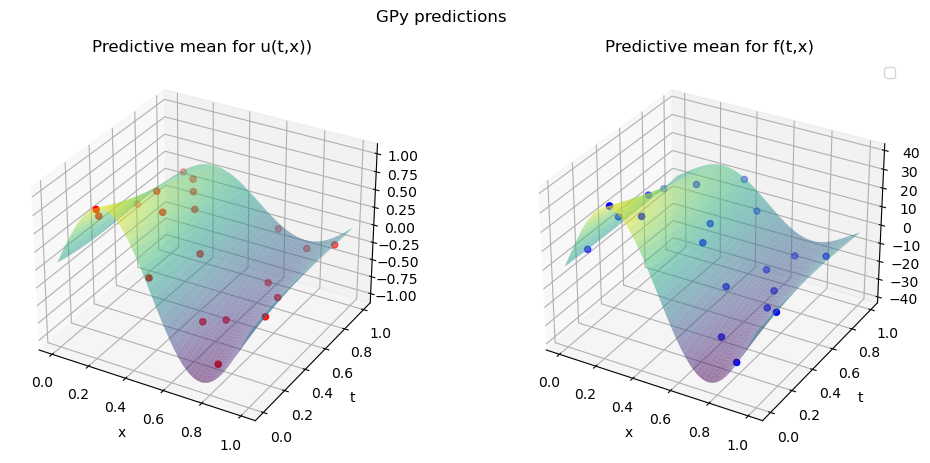

In [12]:
model_heat_equation.use_GPy(X_star,"GPy_predictive_mean",False)

MSE_u:  6.34236679834359e-05
MSE_f:  0.12276169417267291
relative error u:  0.017187518483924146
relative error f:  0.019651781461471667


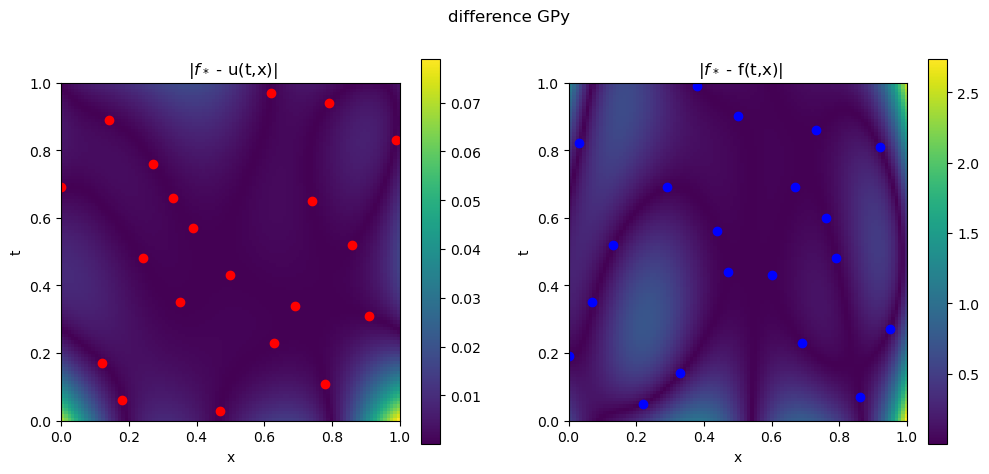

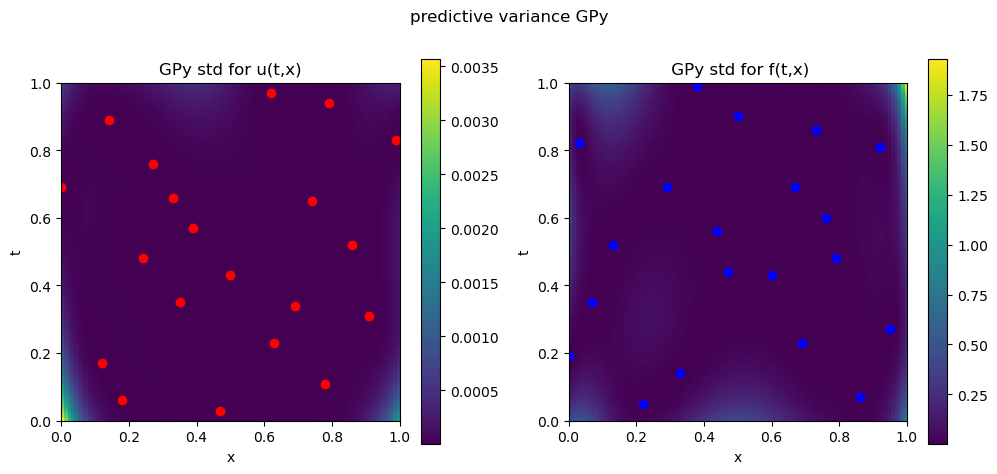

In [13]:
model_heat_equation.plot_difference_GPy("difference GPy ", "GPy_difference.png")
model_heat_equation.plot_variance_GPy("predictive variance GPy ", "GPy_variance.png")

         lx   sigma_f        lt         c  function_values
0  0.424671  0.719453  0.584914  0.265921     1.445215e+06
1  0.779370  0.531919  0.303295  0.443361     3.519945e+05
2  0.388069  0.697436  0.614725  1.001990     5.206127e+00
3  0.286924  0.511174  1.044867  0.787596     2.195168e+04
4  0.296068  0.469335  0.941195  0.999105     1.469038e+00
-6.121881484985352


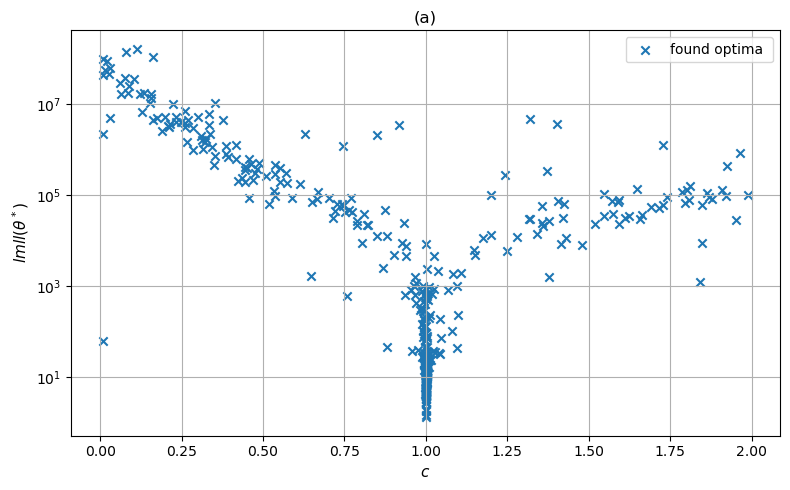

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

results = model_heat_equation.results_list

theta_list = np.array([thet.x for thet in results])
function_values = np.array([thet.fun for thet in results])
df_results = pd.DataFrame(theta_list, columns=["lx", "sigma_f","lt", "c"])
df_results["function_values"] = function_values
print(df_results.head())

df_results = df_results.sort_values(by=["c"])
print(df_results["function_values"].min())
loc_minimum = np.argmin(df_results["function_values"])
#add the minimum to the dataframe in order to make all positive
df_results["function_values"] = df_results["function_values"] - df_results.iloc[loc_minimum, 4]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))

df_results_above_10 = df_results#[df_results["function_values"]>10]
# plot 1
axs.scatter(np.array(df_results_above_10["c"]), ((np.array(df_results_above_10["function_values"]))), marker = "x", label="found optima ")
axs.set_xlabel("$c$", fontsize=11)
axs.set_ylabel("$lmll(\\theta^*)$", fontsize=11)
axs.grid(True)
axs.legend()
axs.set_yscale("log")
axs.set_title("(a)")


plt.tight_layout()
plt.savefig("heat_equation_optim_distribution.png", dpi=300)

In [75]:
# first we put the kernel parts into a list
kernel_list = [gram_Matrix_jax, k_uu_jax, k_uf_jax, k_fu_jax, k_ff_jax]
#then we define the parameters for the kernel
hyperparameters = ["l_x", "sigma_f","l_t", "alpha"]
#now we can define our model. The model needs the kernel list and the hyperparameters, aswell as the timedependence
model_heat_equation_2 = PhysicsInformedGP_regressor(kernel_list,timedependence=True, params=hyperparameters,Dimensions=2)
model_heat_equation_2.set_name_kernel("Wave_equation")
#now we create the training data and a validation set
n_training_points = 10
noise = [1e-8,1e-8]
model_heat_equation_2.set_training_data("heat_data_paper.csv",n_training_points, noise,[5,12])

n_validation_points = 2000  #for calculating the MSE

model_heat_equation_2.set_validation_data(n_validation_points)
#model_heat_equation.plot_raw_data(True,False)

#for the training we first need to define the initial parameters for the restarts
model_heat_equation_2.jitter = 1e-6
def get_initial_values():
    """returns the initial values for the hyperparameters
    for the length scales we initialize them randomly as log(l) ~ U(-1.3,1)
    """
    rng = np.random.default_rng()
    theta_initial = np.zeros((4))
    theta_initial[0] = np.exp(rng.uniform(-1.3, 0.3, 1))  #lx
    theta_initial[1] = rng.uniform(0, 1, 1)               #sigma_f
    theta_initial[2] = np.exp(rng.uniform(-1.3, 0.3, 1))  #lt
    theta_initial[3] = rng.uniform(0, 2, 1)               #c
    return theta_initial

n_restarts = 1000; n_threads = -1
opt_params_dict = {'theta_initial': get_initial_values,   #needed for all optimization methods
                    'bounds': ((1e-2, None), (1e-5, None), (1e-3, None),(1e-2, None)), #needed for TNC and L-BFGS-B
                    'gtol': 1e-6}

model_heat_equation_2.train("TNC",n_restarts, n_threads,opt_params_dict)

 c:\Users\leitg\anaconda3\Lib\site-packages\scipy\stats\_qmc.py:804: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
 c:\Users\leitg\anaconda3\Lib\site-packages\scipy\stats\_qmc.py:804: UserWarning:The balance properties of Sobol' points require n to be a power of 2.











































100%|██████████| 1000/1000 [01:18<00:00, 12.80it/s]


 message: Converged (|x_n-x_(n-1)| ~= 0)
 success: True
  status: 2
     fun: 13.372560501098633
       x: [ 3.660e-01  2.892e+00  1.391e+00  9.961e-01]
     nit: 13
     jac: [ 2.930e-03 -4.016e-02  8.247e-02 -4.436e-01]
    nfev: 87


In [80]:
model_heat_equation_2.get_params()

array([0.36604332, 2.89241452, 1.39064454, 0.9961349 ])

{'u': 0.0001671848149271682, 'f': 0.410449355840683}

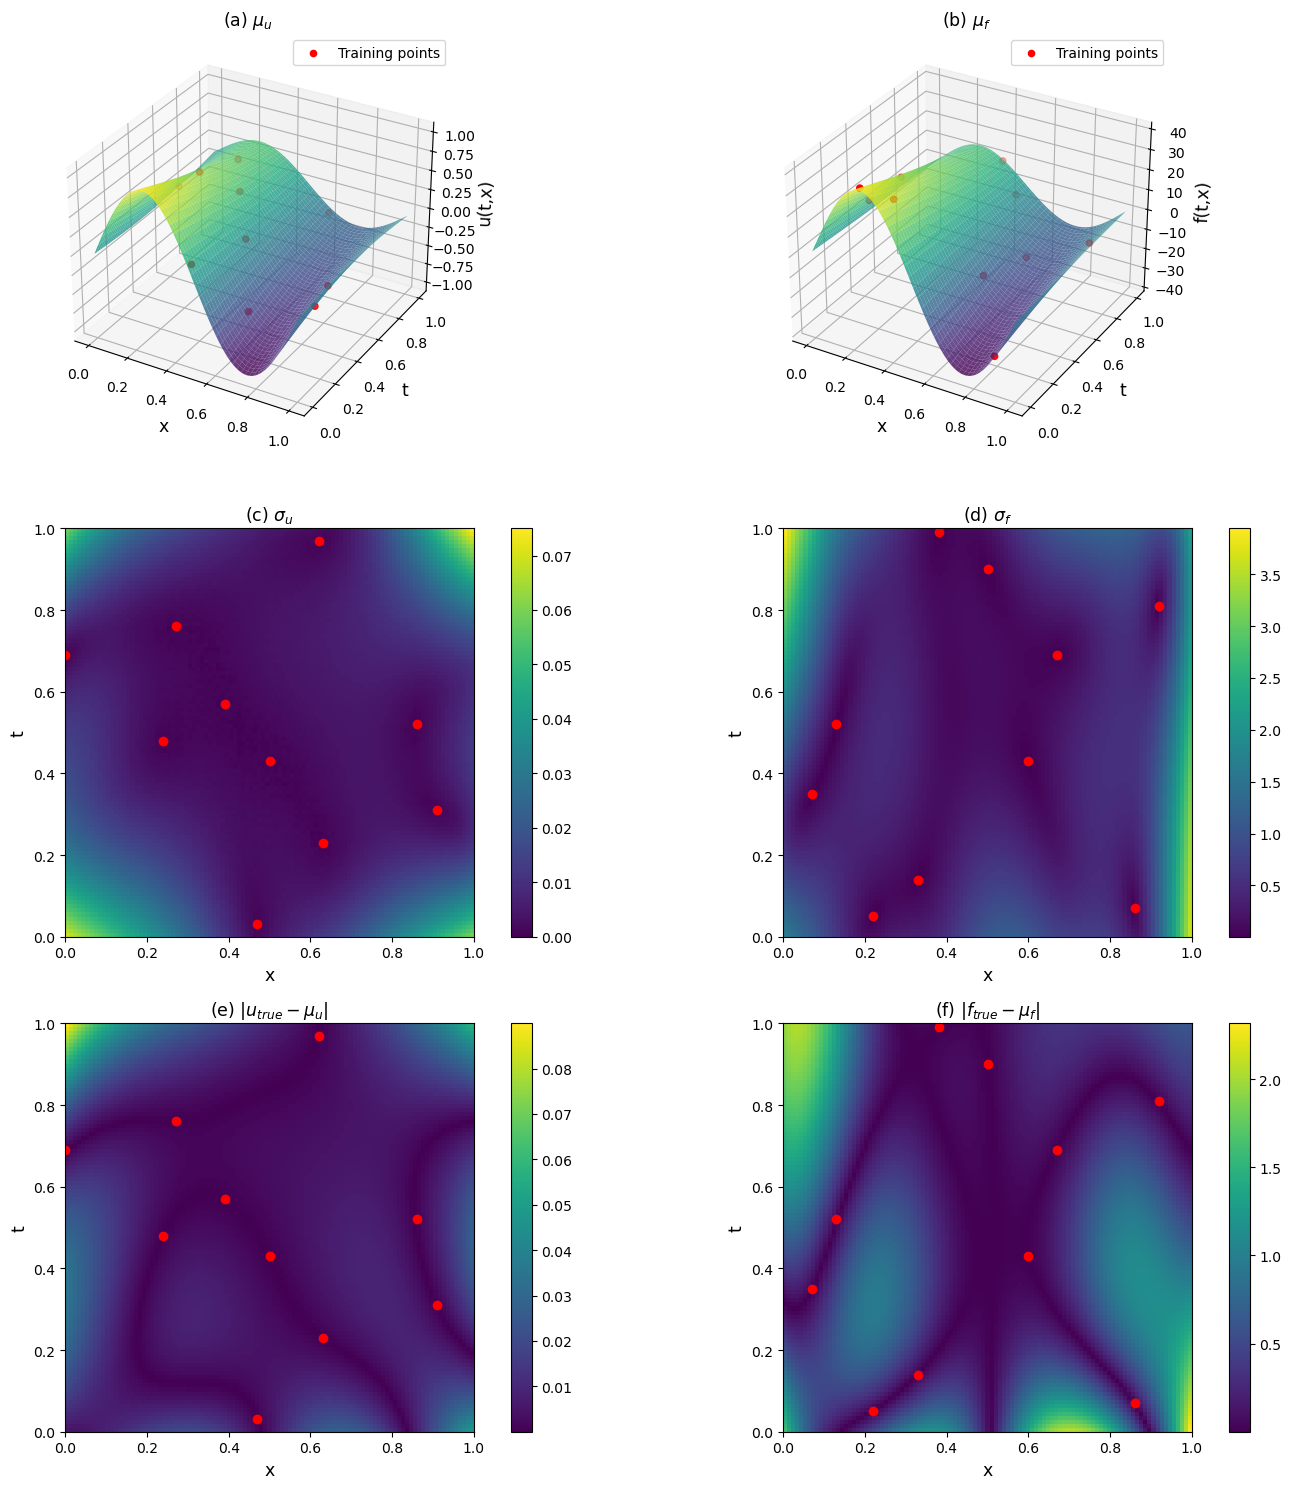

In [86]:
model_heat_equation_2.jitter = 1e-6
model_heat_equation_2.set_axis_labels("x","t")
n_test_points = 100
x_star, t_star = np.meshgrid(np.linspace(0, 1, n_test_points), np.linspace(0, 1, n_test_points))
X_star = np.hstack((x_star.reshape(-1, 1), t_star.reshape(-1, 1)))
model_heat_equation_2.predict_model(X_star)
model_heat_equation_2.error()
#print(model_heat_equation)
var = model_heat_equation_2.var_u
model_heat_equation_2.var_u.min()

model_heat_equation_2.plot_merged_2d_plots(X_star,"merged_plots_2.png",figsize=(15,15))
model_heat_equation_2.MSE

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MSE_u:  0.0022778980121925807
MSE_f:  9.826251263807398
relative error u:  0.10300413005662166
relative error f:  0.1758184397957942


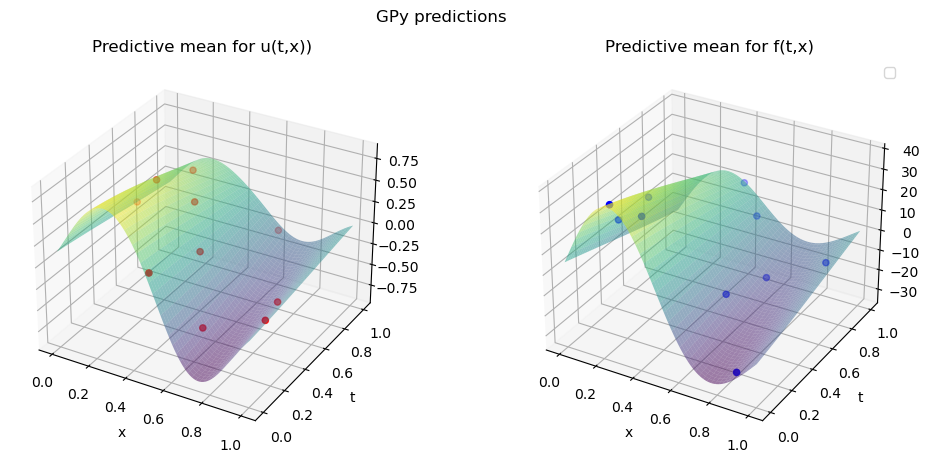

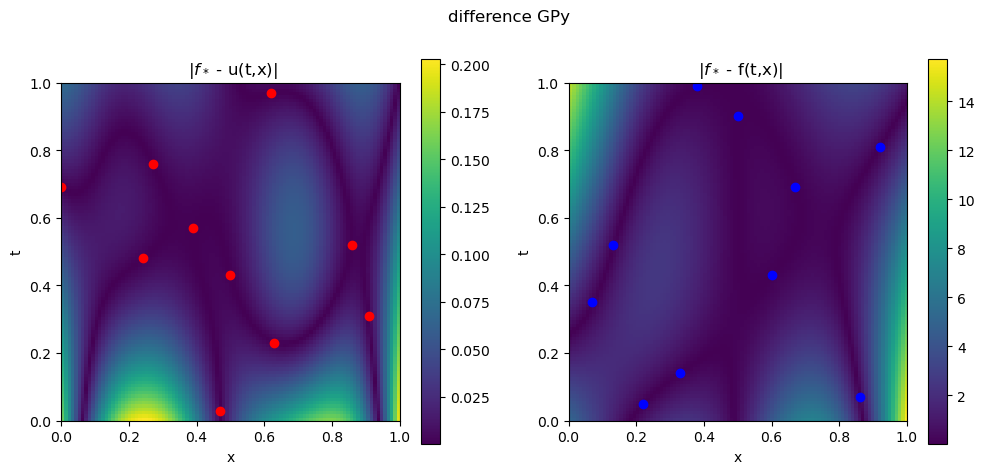

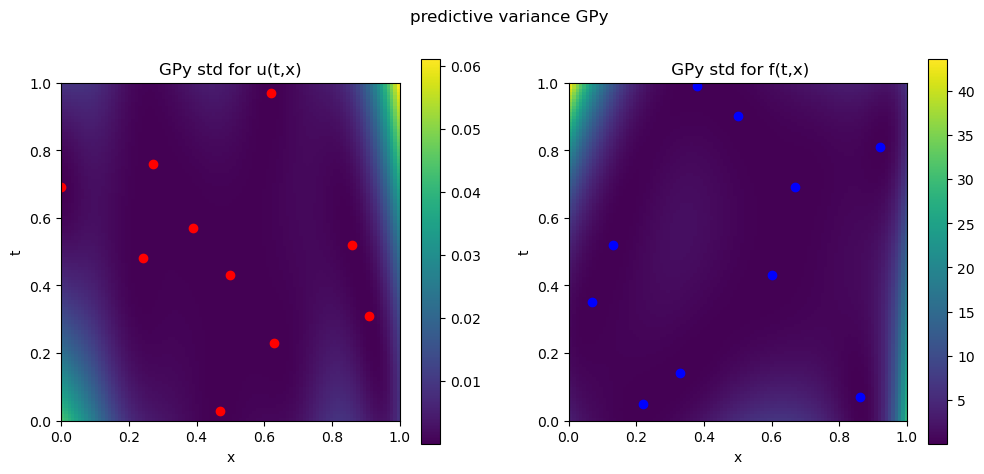

In [83]:
model_heat_equation_2.use_GPy(X_star,"GPy_predictive_mean",False)
model_heat_equation_2.plot_difference_GPy("difference GPy ", None)
model_heat_equation_2.plot_variance_GPy("predictive variance GPy ", None)

         lx   sigma_f        lt         c  function_values
0  0.318290  0.759262  0.932219  1.007779        14.770155
1  0.772635  0.663583  0.744955  0.282411     92485.578125
2  2.054443  0.258320  0.015100  1.845762        28.156227
3  0.345260  1.366765  0.968038  0.995144        14.078939
4  0.324445  0.959101  1.065600  1.008447        14.265512
13.372560501098633


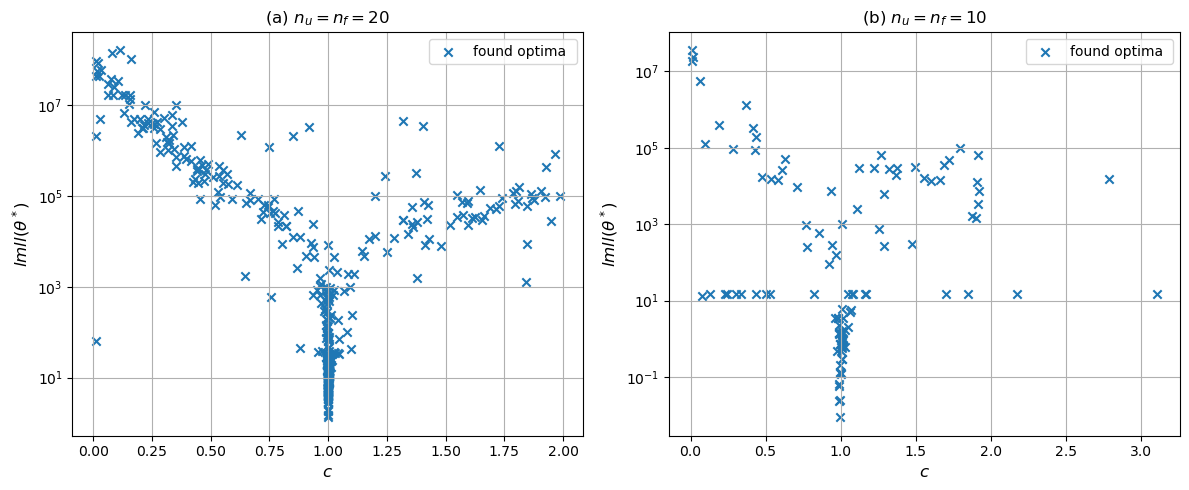

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

results_2 = model_heat_equation_2.results_list

theta_list_2 = np.array([thet.x for thet in results_2])
function_values_2 = np.array([thet.fun for thet in results_2])
df_results_2 = pd.DataFrame(theta_list_2, columns=["lx", "sigma_f","lt", "c"])
df_results_2["function_values"] = function_values_2
print(df_results_2.head())

df_results_2 = df_results_2.sort_values(by=["c"])
print(df_results_2["function_values"].min())
loc_minimum_2 = np.argmin(df_results_2["function_values"])
#add the minimum to the dataframe in order to make all positive
df_results_2["function_values"] = df_results_2["function_values"] - df_results_2.iloc[loc_minimum_2, 4]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

df_results_above_10 = df_results#[df_results["function_values"]>10]

# plot 1
axs[0].scatter(np.array(df_results_above_10["c"]), ((np.array(df_results_above_10["function_values"]))), marker = "x", label="found optima ")
axs[0].set_xlabel("$c$", fontsize=12)
axs[0].set_ylabel("$lmll(\\theta^*)$", fontsize=12)
axs[0].grid(True)
axs[0].legend()
axs[0].set_yscale("log")
axs[0].set_title("(a) $n_u = n_f = 20$", fontsize=12)

axs[1].scatter(np.array(df_results_2["c"]), ((np.array(df_results_2["function_values"]))), marker = "x", label="found optima ")
axs[1].set_xlabel("$c$", fontsize=12)
axs[1].set_ylabel("$lmll(\\theta^*)$", fontsize=12)
axs[1].grid(True)
axs[1].legend()
axs[1].set_yscale("log")
axs[1].set_title("(b) $n_u = n_f = 10$", fontsize=12)


plt.tight_layout()
plt.savefig("heat_equation_optim_distribution_2.png", dpi=300)


In [ ]:
#i want to look at the 10 best results
df_results = df_results.sort_values(by=["function_values"])
df_best_results = df_results.iloc[:15,:]
display(df_best_results)

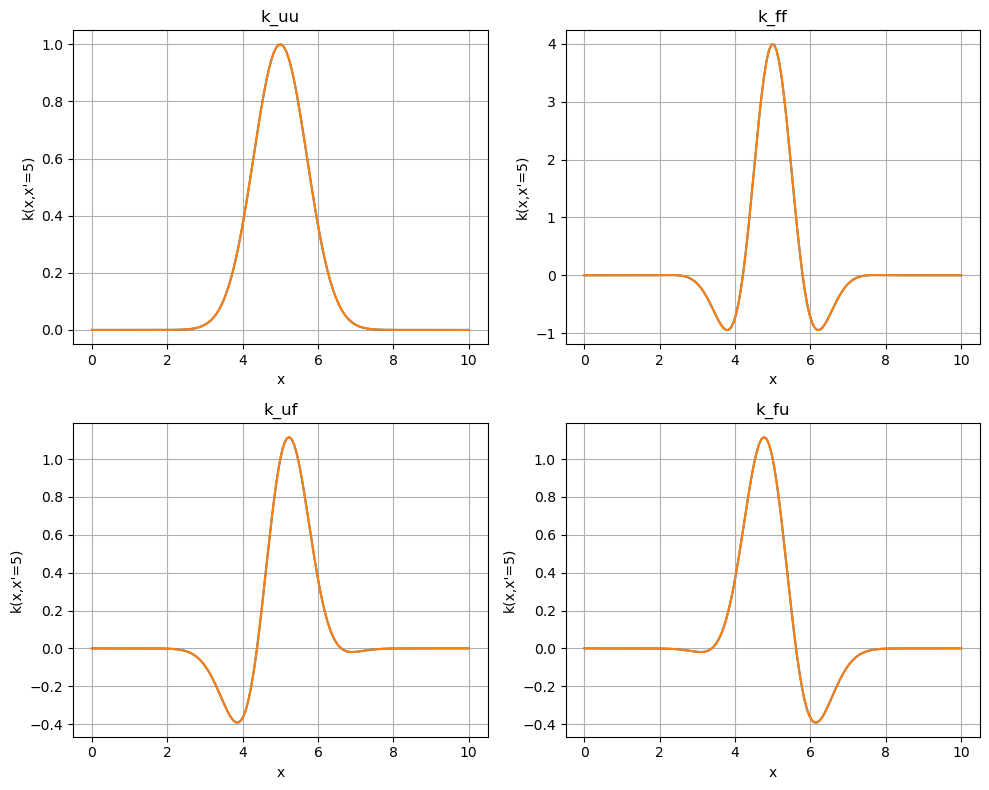

In [23]:
import matplotlib.pyplot as plt
X_star = np.linspace(0,10,150).reshape(-1,1)
T_star = np.linspace(0,10,150).reshape(-1,1)
X_star = np.hstack((X_star,T_star))
pointx = np.array([[5.]])
pointt = np.array([[5]])
point = np.hstack((pointx,pointt))
params = [1.,1.,1.,1]
kernel_kuu = model_heat_equation.k_uu(X_star,point,params)
kernel_kff = model_heat_equation.k_ff(X_star,point,params)
kernel_kuf = model_heat_equation.k_uf(X_star,point,params)
kernel_kfu = model_heat_equation.k_fu(X_star,point,params)

fig, ax = plt.subplots(2,2,figsize=(10,8))
ax[0,0].plot(X_star,kernel_kuu)
ax[0,0].set_title("k_uu")
ax[0,1].plot(X_star,kernel_kff)
ax[0,1].set_title("k_ff")
ax[1,0].plot(X_star,kernel_kuf)
ax[1,0].set_title("k_uf")
ax[1,1].plot(X_star,kernel_kfu)
ax[1,1].set_title("k_fu")
for i in range(2):
    for j in range(2):
        ax[i,j].grid()
        ax[i,j].set_xlabel("x")
        ax[i,j].set_ylabel("k(x,x'=5)")
plt.tight_layout()
